In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pytz
import re
import nltk
import ast
import string
import itertools
import seaborn as sns
from datetime import datetime,timedelta
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.preprocessing import MinMaxScaler

In [2]:
df = pd.read_csv('../Cleaning/Clean_Dataset.csv', encoding='utf-8')
jakarta = pytz.timezone('Asia/Jakarta')
time_date = "%m/%d/%Y %H:%M"
df['datetime_created'] = df['Datetime'].apply(lambda x:datetime.strptime(x,time_date))
df['date_created'] = df['datetime_created'].apply(lambda x:x.date())
df['time_created'] = df['datetime_created'].apply(lambda x:x.time())
df = df.drop(['datetime_created'],axis=1)

In [3]:
len(df)

42403

### Additional Cleaning

In [4]:
#hapus duplikat
df = df.drop_duplicates()
df = df.reset_index(drop=True)

In [5]:
len(df[df['Clean_Text'].isnull() ==  True])

0

In [6]:
pd.set_option('display.max_colwidth', None)
df[df['Clean_Text'].isnull() == True]['Text']

Series([], Name: Text, dtype: object)

In [7]:
df = df.dropna(subset=['Clean_Text'])
df = df.reset_index(drop=True)

In [8]:
df.isnull().sum()

Datetime                 0
Tweet Id                 0
Text                     0
Username                 0
Location             25786
Clean_Text               0
indonlp_sentiment        0
Stop_Words_Text          0
Stemmed_Text             0
language                 0
Translated               0
label_score              0
score                    0
date_created             0
time_created             0
Lexicon_Score            0
Lexicon_Sentiment        0
Score_Scaled             0
label                    0
dtype: int64

In [9]:
df[df['language']!='id']['language'].value_counts()

no    4255
en    2533
et    1669
af    1195
sl    1004
nl     793
it     771
sv     653
sq     582
da     485
ca     397
hr     393
fi     190
ro     132
tr     106
sk      98
tl      87
fr      64
lt      54
pt      35
hu      27
cs      16
lv      12
Name: language, dtype: int64

In [10]:
clean_text = df['Clean_Text'].copy()

In [11]:
pd.set_option('display.max_colwidth', 100)
clean_text.tail(15)

42388    kayaknya sudah tidak mungkin konsep siren tidak selaras sama metaverse mereka kecuali seperti me...
42389                                                                        mungkin cair kalau di metaverse
42390                   walau terus merugi meta bakal lanjutkan proyek metaverse pada tahun berita teknologi
42391    itu ciri kamu yang tidak bisa adaptasi di setiap ruang lingkup pasti ada kebiasan entah itu baik...
42392    angaran belanja untuk perangkat lunak tapi tidak bisa digunakan dengan maksimal ya buat apa pak ...
42393      dapat suntikan us juta dari sbi dan square enix perusahaan game gumi bakal garap bisnis metaverse
42394    saya tdnya ngira memang ada seperti orang dibalik ini semua yang ngatur mereka ke dunia lain tap...
42395                                                     punya dia lagi ngembangin ekosistem metaverse juga
42396    wishnutama selaku founding chairman jagat nusantara optimis bahwa kehadiran metaverse tidak menu...
42397    ekonomi sa

### Cleaning Data

In [12]:
def repair_exaggeration(x):
    word_tokens = word_tokenize(x)
    new_x =''
    for i in word_tokens:
        if (i =='metaversee'):
            new = re.sub(r'(\w)\1\1+',r'\1\1',i)
            new_x = new_x +new+' '
        elif(i =='metavers'):
            new = 'metaverse'
            new_x = new_x +new+' '
        elif(i == 'meta'):
            new = 'metaverse'
            new_x = new_x +new+' '
        else:
            new = re.sub(r'(\w)\1\1\1+',r'\1',i)
            new_x = new_x +new+' '
    return new_x

In [13]:
def del_word(x,key_list):
    n = len(key_list)
    word_tokens = word_tokenize(x)
    new_x =''
    for word in word_tokens:
        if word not in key_list:
            new_x = new_x+word+' '
    return new_x

In [14]:
#gunakan slang dan stopwords untuk membersihkan dataset
# sumber slang dan stop words : https://github.com/louisowen6/NLP_bahasa_resources
def clean_tweets(text):
    my_file = open('../Cleaning/cleaning_source/combined_stop_words.txt','r')
    content = my_file.read()
    stop_words = content.split('\n')
    file_2 = open('../Cleaning/cleaning_source/update_combined_slang_words.txt','r')
    content2 = file_2.read()
    slang_words = ast.literal_eval(content2)
    my_file.close()
    file_2.close()
    
    text = text.lower()
    # Remove url
    text = re.sub(r'https?://[^\s]+','',text)
    # Remove hashtag
    text = re.sub(r'#\w+','',text)
    
    text = re.sub(r':', '', text)
    text = re.sub(r'‚Ä¶', '', text)
    #replace consecutive non-ASCII characters with a space
    text = re.sub(r'[^\x00-\x7F]+',' ', text)
    
    #remove emojis from text
    #text = emoji_pattern.sub(r'',text)
    
    #remove punctuation
    text = re.sub('[^a-zA-Z]',' ', text)
    
    #remove mentio
    text=re.sub('&lt;/?.*?&gt;","&lt;&gt;','',text)
    
    #remove digits and special chars
    text = re.sub("(\\d|\\W)+"," ",text)
    
    #remove other symbol from tweet
    text = re.sub(r'â', '', text)
    text = re.sub(r'€', '', text)
    text = re.sub(r'¦', '', text)
    
    #modify slang word to make it more suitable
    word_tokens = word_tokenize(text)
    for w in word_tokens:
        if w in slang_words.keys():
            word_tokens[word_tokens.index(w)] = slang_words[w]
    
    #filter using NLTK and append it to a string
    filtered_tweet = [w for w in word_tokens if not w in stop_words]
    filtered_tweet = []
    
    #loop through condition
    for w in word_tokens:
        #check tokens against emoticons, punctuations and stopwords
        if w not in string.punctuation and w not in stop_words:
            filtered_tweet.append(w.lower())
            
    return ' '.join(filtered_tweet)

In [15]:
def count_words(x):
    words = word_tokenize(x)
    n=len(words)
    return n

In [16]:
clean_text_exag = clean_text.apply(lambda x:repair_exaggeration(x))

In [17]:
re_clean = clean_text_exag.apply(lambda x: clean_tweets(x))

### Word Processing

In [18]:
#Create Word Dictionary
word_dict = {}
for i in range(0,len(df['Clean_Text'])):
    sentence = df['Clean_Text'][i]
    word_token = word_tokenize(sentence)
    for j in word_token:
        if j not in word_dict:
            word_dict[j] = 1
        else:
            word_dict[j] += 1

In [19]:
len(word_dict)

41222

In [20]:
len({k:v for (k,v) in word_dict.items() if v <4})

29980

# Import Lexicon Data
##### sources:

https://github.com/louisowen6/NLP_bahasa_resources
https://github.com/abhimantramb/elang/blob/master/word2vec/utils/swear-words.txt
https://github.com/fajri91/InSet
https://github.com/agusmakmun/SentiStrengthID/blob/master/id_dict/sentimentword.txt

In [21]:
negasi = ['bukan','tidak','ga','gk','g', 'ngga', 'nggak', 'no']
lexicon = pd.read_csv('Lexicon Dictionary/modified_full_lexicon.csv')
lexicon = lexicon.drop(lexicon[(lexicon['word'] == 'bukan')|
                               (lexicon['word'] == 'tidak')|
                               (lexicon['word'] == 'ga')|
                               (lexicon['word'] == 'gk')|
                               (lexicon['word'] == 'ngga')|
                               (lexicon['word'] == 'nggak')|
                               (lexicon['word'] == 'no')|
                               (lexicon['word'] == 'gk')].index,axis=0)
lexicon = lexicon.reset_index(drop=True)

In [22]:
len(lexicon)

10245

In [23]:
lexicon_word = lexicon['word'].to_list()
lexicon_num_words = lexicon['number_of_words']

In [24]:
#cek jika terdapat kata pada kamus yang tidak terdapat pada kamus lexicon
ns_words = []
#create stemmer
factory = StemmerFactory()
stemmer = factory.create_stemmer()
for word in word_dict.keys():
    if word not in lexicon_word:
        kata_dasar = stemmer.stem(word)
        if kata_dasar not in lexicon_word:
            ns_words.append(word)

In [25]:
print(len(word_dict))
print(len(lexicon))
print(len(ns_words))

41222
10245
33372


In [26]:
ns_words_list = { k:v for (k,v) in word_dict.items() if ((k in ns_words) & (v>3)) }

In [27]:
#sort the most occurences word descending
sort_orders = sorted(ns_words_list.items(), key=lambda x: x[1], reverse = True)
sort_orders = sort_orders[0:20]
for i in sort_orders:
    print(i[0], i[1])

metaverse 44908
di 17328
dan 10232
tidak 8484
ini 8253
bisa 4789
dengan 4641
masih 4368
ke 3875
iya 3866
untuk 3553
tapi 3228
juga 3201
akan 2905
kita 2624
virtual 2501
orang 2336
baru 2256
teknologi 2176
nft 2168


In [28]:
word_to_plot = df['Clean_Text'].copy()

In [29]:
word_to_plot_1 = word_to_plot.apply(lambda x: del_word(x,negasi))

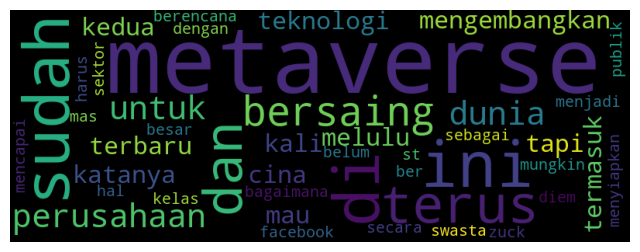

In [30]:
#create a word cloud to see which words that appear often in tweets of metaverse
wordcloud = WordCloud(width = 800, height = 300, background_color = 'black', 
                      max_words = 1000, min_font_size = 20).generate(str(word_to_plot_1))
#plot the word cloud
fig = plt.figure(figsize = (8,8), facecolor = None)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

### Sentiment

In [31]:
lexicon

,word,weight,number_of_words
0,hai,3,1
1,merekam,2,1
2,ekstensif,3,1
3,paripurna,1,1
4,detail,2,1
...,...,...,...
10240,sontoloyo,-5,1
10241,tai,-5,1
10242,telek,-5,1
10243,tolol,-5,1


In [32]:
lexicon['number_of_words'].value_counts()

1    9533
2     686
3      24
4       2
Name: number_of_words, dtype: int64

#### Hitung nilai kata dengan mencocokkan dengan kamus lexicon sementara membuat matrix Bag of Words

In [33]:
sencol =[]
senrow =np.array([])
nsen = 0
factory = StemmerFactory()
stemmer = factory.create_stemmer()
sentiment_list = []
# fungsi untuk menulis nilai kata jika ditemukan
def found_word(ind,words,word,sen,sencol,sentiment,add):
    # jika terdapat pada matrix Bag of Words, tingkatkan nilainya
    if word in sencol:
        sen[sencol.index(word)] += 1
    else:
    # jika tidak, tambahkan kata baru
        sencol.append(word)
        sen.append(1)
        add += 1
    # jika terdapat kata negasi sebelumnya, nilai sentimen akan menjadi negatif
    if (words[ind-1] in negasi):
        sentiment += -lexicon['weight'][lexicon_word.index(word)]
    else:
        sentiment += lexicon['weight'][lexicon_word.index(word)]
    
    return sen,sencol,sentiment,add

In [ ]:
# memeriksa setiap kata, jika terdapat pada kamus lexicon, maka hitung nilai sentimennya
for i in range(len(df)):
    nsen = senrow.shape[0]
    words = word_tokenize(df['Clean_Text'][i])
    sentiment = 0 
    add = 0
    prev = [0 for ii in range(len(words))]
    n_words = len(words)
    if len(sencol)>0:
        sen =[0 for j in range(len(sencol))]
    else:
        sen =[]
    
    for word in words:
        ind = words.index(word)
        # Memeriksa apakah terdapat pada kamus lexicon
        if word in lexicon_word :
            sen,sencol,sentiment,add= found_word(ind,words,word,sen,sencol,sentiment,add)
        else:
        # jika tidak, periksa kata dasarnya
            kata_dasar = stemmer.stem(word)
            if kata_dasar in lexicon_word:
                sen,sencol,sentiment,add= found_word(ind,words,kata_dasar,sen,sencol,sentiment,add)
        # jika masih tidak ditemukan, coba gabungkan dengan kata sebelumnya
            elif(n_words>1):
                if ind-1>-1:
                    back_1    = words[ind-1]+' '+word
                    if (back_1 in lexicon_word):
                        sen,sencol,sentiment,add= found_word(ind,words,back_1,sen,sencol,sentiment,add)
                    elif(ind-2>-1):
                        back_2    = words[ind-2]+' '+back_1
                        if back_2 in lexicon_word:
                            sen,sencol,sentiment,add= found_word(ind,words,back_2,sen,sencol,sentiment,add)
    # if there is new word founded, then expand the matrix
    # jika ditemukan kata baru, maka perluas matrix
    if add>0:  
        if i>0:
            if (nsen==0):
                senrow = np.zeros([i,add],dtype=int)
            elif(i!=nsen):
                padding_h = np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding_h))
                padding_v = np.zeros([(i-nsen),senrow.shape[1]],dtype=int)
                senrow = np.vstack((senrow,padding_v))
            else:
                padding =np.zeros([nsen,add],dtype=int)
                senrow = np.hstack((senrow,padding))
            senrow = np.vstack((senrow,sen))
        if i==0:
            senrow = np.array(sen).reshape(1,len(sen))
    # if there isn't then just update the old matrix
    # jika tidak, perbarui matrix lama
    elif(nsen>0):
        senrow = np.vstack((senrow,sen))
        
    sentiment_list.append(sentiment)

In [ ]:
len(sentiment_list)

In [ ]:
print(sencol)

In [ ]:
print(senrow.shape[0])

In [ ]:
sencol.append('lexicon_score')
sentiment_array = np.array(sentiment_list).reshape(senrow.shape[0],1)
sentiment_data = np.hstack((senrow,sentiment_array))
df_sen = pd.DataFrame(sentiment_data,columns = sencol)

In [ ]:
df_sen.head(10)

In [ ]:
#df_sen = df_sen.drop(df_sen.columns[0], axis=1)

In [ ]:
df_sen.head()

In [ ]:
cek_df = pd.DataFrame([])
cek_df['text'] = df['Clean_Text'].copy()
cek_df['lexicon_score'] = df_sen['lexicon_score'].copy()

In [ ]:
cek_df.head(10)

In [ ]:
df['Lexicon_Score'] = cek_df['lexicon_score']

In [ ]:
print(max(df['Lexicon_Score']))
print(min(df['Lexicon_Score']))

In [ ]:
scaler = MinMaxScaler()
sentiment_scores = df['Lexicon_Score'].values

In [ ]:
scale_score = scaler.fit_transform(sentiment_scores.reshape(-1,1))

In [ ]:
df['Score_Scaled'] = scale_score

In [ ]:
def sentiment(score):
    if score >= 0.75:
        return 'positive'
    elif score <= 0.25:
        return 'negative'
    else:
        return 'neutral'

In [ ]:
df['Lexicon_Sentiment'] = df['Score_Scaled'].apply(lambda x: sentiment(x))

In [ ]:
X = df['Clean_Text']
y = df['Lexicon_Sentiment']

x_train, x_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state=42)

In [ ]:
y_true = df['indonlp_sentiment'][:round(len(df)*0.2)]
y_pred = df['Lexicon_Sentiment'][:round(len(df)*0.2)]

In [ ]:
# Calculate the accuracy, precision, recall, and F1-score
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

In [ ]:
# Print the results
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1-score: {:.2f}%'.format(f1 * 100))

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def sentiment(score, pos_threshold, neg_threshold):
    if score >= pos_threshold:
        return 'positive'
    elif score <= neg_threshold:
        return 'negative'
    else:
        return 'neutral'

def find_best_threshold(df):
    pos_thresholds = np.arange(0.4, 1, 0.05)
    neg_thresholds = np.arange(0, 0.3, 0.05)
    best_pos_threshold = 0
    best_neg_threshold = 0
    best_accuracy = 0
    for pos_threshold in pos_thresholds:
        for neg_threshold in neg_thresholds:
            df['predicted_sentiment'] = df['Score_Scaled'].apply(lambda x: sentiment(x, pos_threshold, neg_threshold))
            y_true = df['indonlp_sentiment'][:round(len(df)*0.2)]
            y_pred = df['predicted_sentiment'][:round(len(df)*0.2)]
            accuracy = accuracy_score(y_true, y_pred)
            if accuracy > best_accuracy:
                best_accuracy = accuracy
                best_pos_threshold = pos_threshold
                best_neg_threshold = neg_threshold
    return best_pos_threshold, best_neg_threshold, best_accuracy

best_pos_threshold, best_neg_threshold, best_accuracy = find_best_threshold(df)
print('Best positive threshold: {:.2f}'.format(best_pos_threshold))
print('Best negative threshold: {:.2f}'.format(best_neg_threshold))
print('Best accuracy: {:.2f}%'.format(best_accuracy * 100))

# Apply the best thresholds to predict sentiment
df['predicted_sentiment'] = df['Score_Scaled'].apply(lambda x: sentiment(x, best_pos_threshold, best_neg_threshold))

# Calculate the accuracy, precision, recall, and F1-score
y_true = df['indonlp_sentiment'][:round(len(df)*0.2)]
y_pred = df['predicted_sentiment'][:round(len(df)*0.2)]
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='macro')
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Print the results
print('Accuracy: {:.2f}%'.format(accuracy * 100))
print('Precision: {:.2f}%'.format(precision * 100))
print('Recall: {:.2f}%'.format(recall * 100))
print('F1-score: {:.2f}%'.format(f1 * 100))


In [ ]:
#df.to_csv('../Cleaning/Clean_Dataset.csv', index=False)

In [ ]:
df.shape

#### EDA

In [ ]:
df_sen.head()

In [ ]:
sns.set(style='white', palette='muted', color_codes=True)
sns.kdeplot(df_sen['lexicon_score'], color='m', shade=True)
plt.title('Sentiment Distribution')
plt.xlabel('sentiment')

In [ ]:
df_sen.describe()

In [ ]:
#correlation between words that is included in the sentiment
def get_redundant_pairs(df):
    '''Get diagonal and lower triangular pairs of correlation matrix'''
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=10):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr

#print("Top Absolute Correlations")
#print(get_top_abs_correlations(df_sen, 10))
au = get_top_abs_correlations(df_sen, 15)

In [ ]:
print('Perfect Correlation')
au[au==1]

In [ ]:
top10 = au[au<float(1)][0:10]
label = top10.index
label_list =[]
for i in label:
    for j in i:
        if(j not in label_list):
            label_list.append(j)
            
df_sen_corr = df_sen[label_list]
corr = df_sen_corr.corr()
for i in label_list:
    for j in label_list:
        if i!=j:
            corr[i][j] = round(corr[i][j],3)
            

In [ ]:
plt.figure(figsize=(15,15))
h = sns.heatmap(corr, annot=True,vmin=-1, vmax=1, center= 0)
plt.show()

In [ ]:
#top15 = au[au<float(1)][0:15]

In [ ]:
'''
pal =sns.dark_palette("purple", input="xkcd",n_colors=15)
g = sns.barplot(y = top15.index , x = top15,palette=pal)
g.grid=False
plt.xlabel('correlation')
plt.ylabel('pair of words')
plt.title("Top 15 Not-Perfect Correlation",fontweight='bold') 
for i in range(15):
    g.text(top15[i],i+0.22, round(top15[i],3),color='black')
plt.show()
'''

In [ ]:
top15_word = df_sen.drop(['lexicon_sentiment'], axis=1).sum().sort_values(ascending=False)[0:15]

In [ ]:
#pal =sns.dark_palette("purple", input="xkcd",n_colors=15)
pal =sns.light_palette("navy", reverse=True,n_colors=15)
g = sns.barplot(y = top15_word.index , x = top15_word,palette=pal)
g.grid(False)
plt.xlabel('Occurences')
plt.ylabel('Words')
plt.title("Top 15 Most Often Occured Words",fontweight='bold') 
for i in range(15):
    g.text(top15_word[i],i+0.22, top15_word[i],color='black')
plt.show()

### Beyond Words

In [ ]:
#pass the sentiment into the original dataset and explore some data
df['Lexicon_Sentiment'] = df_sen['lexicon_sentiment']

In [ ]:
df.sample(15)

In [ ]:
df.isnull().sum()

In [ ]:
plt.figure()
plt.title('correlation between numerical data', fontweight='bold')
df_corr = df.corr()
matrix = np.triu(df.corr())
cmap = sns.cubehelix_palette(light=0.5, as_cmap=True)
h = sns.heatmap(df_corr, annot=True, vmin=-1, vmax=1, center=0, mask=matrix, cmap = cmap)

plt.show()

In [ ]:
df_location = df.groupby(['Location']).mean().sort_values(by='Lexicon_Sentiment',ascending=False)
df_location = df_location.reset_index()

In [ ]:
df_location_dict = df.groupby(['Location']).count().sort_values(by='Tweet Id',ascending=False)['Tweet Id'].to_dict()

In [ ]:
df_location['number_of_tweets'] =  df_location.apply(lambda x:df_location_dict[x['Location']],axis=1)

In [ ]:
top10_location_positive = df_location.sort_values(by='Lexicon_Sentiment', ascending=False)[0:10].reset_index(drop=True)
top10_location_negative = df_location.sort_values(by='Lexicon_Sentiment', ascending=True)[0:10].reset_index(drop=True)
top10_location = df_location.sort_values(by='number_of_tweets', ascending=False)[0:10].reset_index(drop=True)

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1,figsize=(10,10))
fig.suptitle('Most Positive and Most Negative Sentiment Place', fontweight='bold')
h = sns.barplot(y='Location', x='Lexicon_Sentiment', data=top10_location_positive, ax=ax1, palette=sns.color_palette('Blues_d', n_colors=10))
n = sns.barplot(y='Location', x='Lexicon_Sentiment', data=top10_location_negative, ax=ax2, palette=sns.color_palette('RdPu_d', n_colors=10))
ax1.set_title('Top 10 Positive')
ax2.set_title('Top 10 Negative')
plt.show()

In [ ]:
#place where tweets is most often come from
pal =sns.dark_palette("green", input="xkcd",n_colors=10)
g = sns.barplot(y = top10_location['Location'] , x = top10_location['number_of_tweets'],palette=pal)
g.grid=False
plt.xlabel('Number of Tweets')
plt.ylabel('Location')
plt.title("Top 10 Number of Tweets place",fontweight='bold') 

for i in range(10):
    g.text(top10_location['number_of_tweets'][i], i+0.22 ,round(top10_location['Lexicon_Sentiment'][i],3),color='black')
    
plt.show()